<a href="https://colab.research.google.com/github/AbrahamJacob89/PythonIntroGUI/blob/main/SignalAnalysisCoursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Signal Analysis Coursework

The aim is to quantify fatigue from surface EMG data, but before doing analysis steps must be taken to minimise errors and remove noise.

Firstly in this case, data from the force plates is used to determine when the press-up hold is ongoing and the data is trimmed to the time when the hold is fully in place. Next a mean offset correction is done for the voltage output to make sure it is not affected by any constant bias. Noise filtering is then done using a bandpass filter to filter frequencies above 450 Hz and below 20 Hz and a notch filter to filter frequencies at 50 Hz. The 450 Hz is chosen as there should be little to no EMG signal above this frequency, so it can be taken as noise. At low frequencies there are contaminants from other spectra (such as ECG or baseline noise from the equipment) so 20 Hz is used as the best compromise for removing noise and preserving signal. Finally the notch filter is to remove power line interference, a prominent source of ambient noise at 50 Hz [1].

There are various methods to quantify fatigue but chosen here are RMS of output voltage which increases linearly with fatigue and, after transforming to the frequency domain, mean and median frequency, which can be calculated from the power spectral density, should decrease linearly with fatigue [2]. In this setup fatigue should increase with time in the hold so these quantities are plotted against time.

[1] Boyer M, Bouyer L, Roy JS, Campeau-Lecours A. Reducing Noise, Artifacts and Interference in Single-Channel EMG Signals: A Review. Sensors (Basel). 2023 Mar 8;23(6):2927. doi: 10.3390/s23062927. PMID: 36991639; PMCID: PMC10059683.

[2] Wang J, Pang M, Yu P, Tang B, Xiang K, Ju Z. Effect of Muscle Fatigue on Surface Electromyography-Based Hand Grasp Force Estimation. Appl Bionics Biomech. 2021 Feb 15;2021:8817480. doi: 10.1155/2021/8817480. PMID: 33628332; PMCID: PMC7899761.


In [ ]:
import numpy as np #For various mathematical functions and arrays
import matplotlib.pyplot as plt # Necessary for plotting data
import scipy.signal as sg # For signal processing methods
from scipy.fft import rfft, rfftfreq # For fast Fourier transform functions

# To begin with define the functions that our program is going to call

# Function to open the csv file read the data an array

def open_csv():

  # These packages are needed to open the file and read into an array.

  from google.colab import files
  import io

  # Upload a csv data file and read into raw-data array, the skip_header removes the title row so the array contains only the raw data.

  uploaded=files.upload()
  a=list(uploaded.keys())
  raw_data = np.genfromtxt (io.BytesIO(uploaded[a[0]]), delimiter=',', skip_header=True)

  #Note that the columns represent the following data i.e raw data [:,0] is all rows of columns 0
  #Column [0] = Time (secs)
  #Column [1] = Force in z direction of left plate (Newtons)
  #Column [2] = Force in z direction of right plate (Newtons)
  #Column [3] = Left Serratus Anterior (Volts)
  #Column [4] = Right Serratus Anterior (Volts)
  #Column [5] = Left Pectoralis Major (Volts)
  #Column [6] = Right Pectoralis Major (Volts)
  #Column [7] = Left Deltoid Anterior (Volts)
  #Column [8] = Right Deltoid Anterior (Volts)
  #Column [9] = Left Triceps (Volts)
  #Column [10] = Right Triceps (Volts)

  return raw_data


# Function for plotting out graphs of all 8 muscles.

def muscle_plots(data, maintitle, xaxislabel = "Time (s)", yaxislabel = "Volts (V)"):

  fig, axes = plt.subplots(2,4,figsize= (30,12));  # Setting up plots so there are 2 rows of 4 plots.

  # This code just arranges and labels all the graphs.

  axes[0,0].plot(data[:,0], data[:,3])
  axes[0,0].set_title('Left Serratus Anterior')
  axes[0,1].plot(data[:,0], data[:,4])
  axes[0,1].set_title('Right Serratus Anterior')
  axes[0,2].plot(data[:,0], data[:,5])
  axes[0,2].set_title('Left Pectoralis Major')
  axes[0,3].plot(data[:,0], data[:,6])
  axes[0,3].set_title('Right Pectoralis Major')
  axes[1,0].plot(data[:,0], data[:,7])
  axes[1,0].set_title('Left Deltoid Anterior')
  axes[1,1].plot(data[:,0], data[:,8])
  axes[1,1].set_title('Right Deltoid Anterior')
  axes[1,2].plot(data[:,0], data[:,9])
  axes[1,2].set_title('Left Triceps')
  axes[1,3].plot(data[:,0], data[:,10])
  axes[1,3].set_title('Right Triceps')
  fig.tight_layout(pad=5.0)
  fig.suptitle(maintitle, size = 'xx-large', weight = 'extra bold')
  fig.supxlabel(xaxislabel, size = 'large', weight = 'extra bold')
  fig.supylabel(yaxislabel, size = 'large', weight = 'extra bold')


  plt.show()

  return

# Function to plot out Fz left and right in one plot to show region of time where the force is stable

def force_plot(data):
  plt.plot(raw_data[:,0], raw_data[:,1])
  plt.plot(raw_data[:,0], raw_data[:,2])
  plt.title('Force on pads (in z - direction)', fontsize = 'xx-large', fontweight = 'extra bold')
  plt.xlabel('Time (s)',fontsize = 'large', fontweight = 'extra bold')
  plt.ylabel('Force (N)', fontsize = 'large', fontweight = 'extra bold')
  plt.grid()
  plt.show()

  return

# Function to remove entries when there is not enough force on the plates using cutoff time values.

def remove_unstable_Fz_data (data, t_cutoff_low, t_cutoff_high):

  remaining_indices = np.where((data[:,0] >= t_cutoff_low) & (data[:,0] < t_cutoff_high))
  hold_data = data[remaining_indices]

  return hold_data


# Function to apply a mean offset to correct any constant voltage bias.

def mean_offset(data):

  offset_data = data.copy() # To make sure output is same format as original.

  # Simply subtracting the mean from the data values to centre the voltage distribution around 0.
  # Note that the time and force columns do not need to be changed.

  offset_data[:,3] = data[:,3] - np.mean(data[:,3])
  offset_data[:,4] = data[:,4] - np.mean(data[:,4])
  offset_data[:,5] = data[:,5] - np.mean(data[:,5])
  offset_data[:,6] = data[:,6] - np.mean(data[:,6])
  offset_data[:,7] = data[:,7] - np.mean(data[:,7])
  offset_data[:,8] = data[:,8] - np.mean(data[:,8])
  offset_data[:,9] = data[:,9] - np.mean(data[:,9])
  offset_data[:,10] = data[:,10] - np.mean(data[:,10])

  return offset_data

# Function uses cutoff values and nyquist frequency to perform butterworth filter
# Returns numerator (b) and denominator (a) polynomials of the filter.

def butter_bandpass(lowcut, highcut, nq, order=4):

  low = lowcut / nq
  high = highcut / nq
  b, a = sg.butter(order, [low, high], btype='band')

  return b, a


# Function uses notch frequency and sampling frequency to perform a second order notch filter
# Returns numerator (b) and denominator (a) polynomials of the filter.

def notch(f0, fs, quality_factor = 30.):

  b, a = sg.iirnotch(f0, quality_factor, fs)

  return b, a


# Function to apply filter to data set

def noise_filter(b, a, data):

  filtered_data = data.copy() # To make sure output is same format as original.

  # Applying filter function with the parameters inputted
  # Note that the time and force columns do not need to be changed.

  filtered_data[:,3] = sg.filtfilt(b, a, data[:,3])
  filtered_data[:,4] = sg.filtfilt(b, a, data[:,4])
  filtered_data[:,5] = sg.filtfilt(b, a, data[:,5])
  filtered_data[:,6] = sg.filtfilt(b, a, data[:,6])
  filtered_data[:,7] = sg.filtfilt(b, a, data[:,7])
  filtered_data[:,8] = sg.filtfilt(b, a, data[:,8])
  filtered_data[:,9] = sg.filtfilt(b, a, data[:,9])
  filtered_data[:,10] = sg.filtfilt(b, a, data[:,10])

  return filtered_data


#Function to calculate window parameters based on n number of windows and timeframe of data

def set_window(data, n):
  start_time = data[0,0] # Start time of loop
  timeframe = round(data[-1,0] - start_time) # Timeframe of data
  window_timeframe = timeframe / n  # This is the timeframe of each window
  first_point_time = start_time + (window_timeframe / 2)  # This is the time of first point taken as the start time add half the window
  windowlen = len(data) // n # windowlen is the no of array elements in the window

  return window_timeframe, first_point_time, windowlen


# Function to calculate the RMS of n time windows for all the muscles
# Takes in data and default n = 54 for 0.5 second windows as our timeframe is 27 seconds after removing unstable force data

def rms_calc(data, n = 54):
  wtf, fpt, wl = set_window(data, n) # Calling function to set window parameters
  rms = []

  for i in range(9):        # To fill array with time and the 8 muscles
    rms.append([])
    for j in range(n):
      if i == 0:            # For adding in the new times to the array
        time = fpt + j*wtf  # The time is taken as the first point time add the window number multiplied by the window timeframe
        rms[i].append(time)
      if i > 0:
        window_rms = np.sqrt(np.mean(np.square(data[j*wl:(j+1)*wl,i+2])))  # Here is our root mean square of the window for each muscle type, i+2 to skip over force data
        rms[i].append(window_rms)

  return rms


# Function to calculate the mean frequency of n time windows for all the muscles
# Takes in data and default n = 54 for 0.5 second windows as our timeframe is 27 seconds after removing unstable force data

def mean_freq_calc(data, n = 54): # Function works same as other rms_calc to get time and loop over muscles

  wtf, fpt, wl = set_window(data, n)
  mnf = []

  for i in range(9):
    mnf.append([])
    for j in range(n):
      if i == 0:
        time = fpt + j*wtf
        mnf[i].append(time)
      if i > 0:
        n_samp = len(data[j*wl:(j+1)*wl,i+2])    # Calculating number of samples in each time window
        t_interval = wtf / n_samp                # Need the time interval to get the frequencies when FFT (note this should be the same as 1/samp_freq)
        xf = rfftfreq (n_samp, t_interval)       # Getting frequencies with FFT note using rfft as want real frequencies (i.e positive)
        yf = rfft(data[j*wl:(j+1)*wl,i+2])       # Doing FFT of voltages in our time window, i+2 to skip over the force data
        psd = (2.0/n_samp**2) * np.abs(yf)**2    # This is formula to calculate the power spectrum density of real frequencies
        window_mean = (psd*xf).sum() / psd.sum() # Calculating the mean for our time window
        mnf[i].append(window_mean)

  return mnf


# Function to calculate the median frequency of n time windows for all the muscles
# Takes in data and default n = 54 for 0.5 second windows as our timeframe is 27 seconds after removing unstable force data

def median_freq_calc(data, n = 54): # Function works same as other rms_calc to get time and loop over muscles

  wtf, fpt, wl = set_window(data, n)
  mdf = []

  for i in range(9):
    mdf.append([])
    for j in range(n):
      if i == 0:
        time = fpt + j*wtf
        mdf[i].append(time)
      if i > 0:
        n_samp = len(data[j*wl:(j+1)*wl,i+2]) # Same as mnf_calc to do rffts and calculate psd
        t_interval = wtf / n_samp
        xf = rfftfreq (n_samp, t_interval)
        yf = rfft(data[j*wl:(j+1)*wl,i+2])
        psd = (2.0/n_samp**2) * np.abs(yf)**2
        halfpsdsum = psd.sum()/2 # The median is when the sum of the psd is equal on both sides so need the half psd sum value

        # Following code is a loop that goes through summing the psd till it reaches the half psd sum value.
        # The counter index can then be used in xf to give the frequency of the median for the window

        index = 0
        current_sum = 0
        for k in psd:
          current_sum = current_sum + k
          if current_sum > halfpsdsum:
            break
          index = index + 1
        window_median = xf[index]
        mdf[i].append(window_median)

  return mdf


# Function to make scatter plots for all the muscles and make linear fits

def scatter_plot(data, maintitle, yaxislabel):

  from scipy import stats # Want this for a linear least-squares regression and to give: r Pearson correlation and p-value

  # Similarly to before but scatter plots (also data is in a different format than earlier)
  fig, axes = plt.subplots(2,4,figsize= (30,12));
  axes[0,0].scatter(data[0], data[1])
  axes[0,0].set_title('Left Serratus Anterior')
  lsa = stats.linregress(data[0], data[1]) # This fits linear least squares regression for left serratus anterior
  axes[0,0].plot(data[0], lsa.intercept + lsa.slope*np.array(data[0]), 'r', label='m={0:.3g} c = {1:.3g}\n r = {2:.3g}, p = {3:.3g}'.format(lsa.slope, lsa.intercept, lsa.rvalue, lsa.pvalue))
  axes[0,0].legend()   # These lines plots the straight line giving the gradient m, the intercept c, the Pearson correlation r and the p-value p in the legend.
  # Simply repeating for all muscles
  axes[0,1].scatter(data[0], data[2])
  axes[0,1].set_title('Right Serratus Anterior')
  rsa = stats.linregress(data[0], data[2])
  axes[0,1].plot(data[0], rsa.intercept + rsa.slope*np.array(data[0]), 'r', label='m={0:.3g} c = {1:.3g}\n r = {2:.3g}, p = {3:.3g}'.format(rsa.slope, rsa.intercept, rsa.rvalue, rsa.pvalue))
  axes[0,1].legend()
  axes[0,2].scatter(data[0], data[3])
  axes[0,2].set_title('Left Pectoralis Major')
  lpm = stats.linregress(data[0], data[3])
  axes[0,2].plot(data[0], lpm.intercept + lpm.slope*np.array(data[0]), 'r', label='m={0:.3g} c = {1:.3g}\n r = {2:.3g}, p = {3:.3g}'.format(lpm.slope, lpm.intercept, lpm.rvalue, lpm.pvalue))
  axes[0,2].legend()
  axes[0,3].scatter(data[0], data[4])
  axes[0,3].set_title('Right Pectoralis Major')
  rpm = stats.linregress(data[0], data[4])
  axes[0,3].plot(data[0], rpm.intercept + rpm.slope*np.array(data[0]), 'r', label='m={0:.3g} c = {1:.3g}\n r = {2:.3g}, p = {3:.3g}'.format(rpm.slope, rpm.intercept, rpm.rvalue, rpm.pvalue))
  axes[0,3].legend()
  axes[1,0].scatter(data[0], data[5])
  axes[1,0].set_title('Left Deltoid Anterior')
  lda = stats.linregress(data[0], data[5])
  axes[1,0].plot(data[0], lda.intercept + lda.slope*np.array(data[0]), 'r', label='m={0:.3g} c = {1:.3g}\n r = {2:.3g}, p = {3:.3g}'.format(lda.slope, lda.intercept, lda.rvalue, lda.pvalue))
  axes[1,0].legend()
  axes[1,1].scatter(data[0], data[6])
  axes[1,1].set_title('Right Deltoid Anterior')
  rda = stats.linregress(data[0], data[6])
  axes[1,1].plot(data[0], rda.intercept + rda.slope*np.array(data[0]), 'r', label='m={0:.3g} c = {1:.3g}\n r = {2:.3g}, p = {3:.3g}'.format(rda.slope, rda.intercept, rda.rvalue, rda.pvalue))
  axes[1,1].legend()
  axes[1,2].scatter(data[0], data[7])
  axes[1,2].set_title('Left Triceps')
  ltc = stats.linregress(data[0], data[7])
  axes[1,2].plot(data[0], ltc.intercept + ltc.slope*np.array(data[0]), 'r', label='m={0:.3g} c = {1:.3g}\n r = {2:.3g}, p = {3:.3g}'.format(ltc.slope, ltc.intercept, ltc.rvalue, ltc.pvalue))
  axes[1,2].legend()
  axes[1,3].scatter(data[0], data[8])
  axes[1,3].set_title('Right Triceps')
  rtc = stats.linregress(data[0], data[8])
  axes[1,3].plot(data[0], rtc.intercept + rtc.slope*np.array(data[0]), 'r', label='m={0:.3g} c = {1:.3g}\n r = {2:.3g}, p = {3:.3g}'.format(rtc.slope, rtc.intercept, rtc.rvalue, rtc.pvalue))
  axes[1,3].legend()
  fig.tight_layout(pad=8.0)
  fig.suptitle(maintitle, size = 'xx-large', weight = 'extra bold')
  fig.supxlabel('Time (s)', size = 'large', weight = 'extra bold')
  fig.supylabel(yaxislabel, size = 'large', weight = 'extra bold')
  plt.show()

  return


In [ ]:
# Next running through the code with various plots taken to check that everything is working as intended.

raw_data = open_csv() # Running our function that opens file and reads the data into the variable raw_data. The user must choose the file to open

Saving 7MIGEP22-23_2023.csv to 7MIGEP22-23_2023.csv


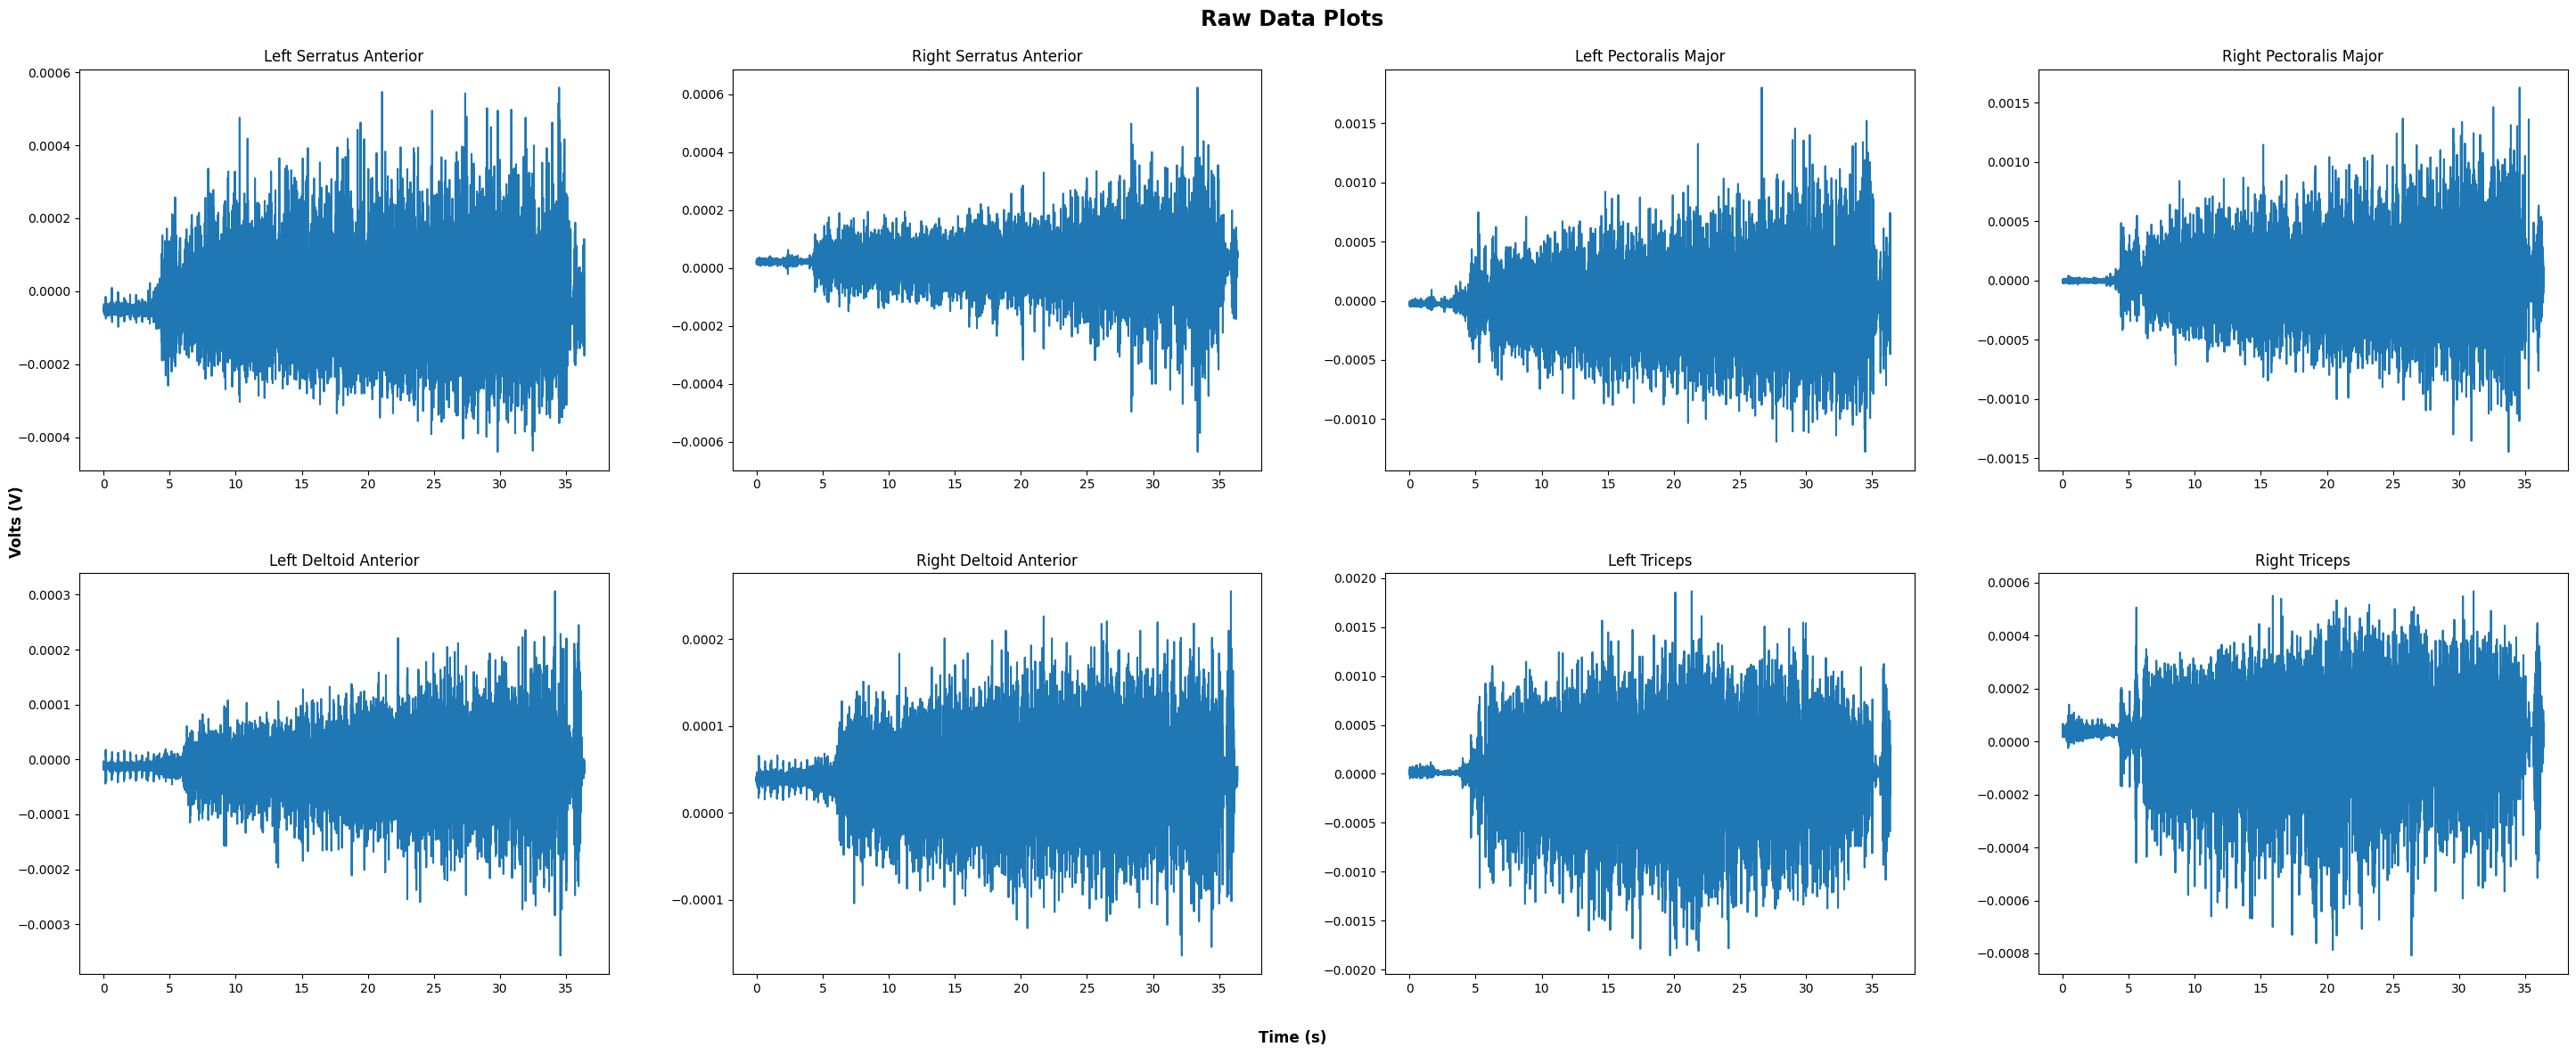

In [ ]:
muscle_plots(raw_data, "Raw Data Plots") # Plotting the raw data for each of the muscles

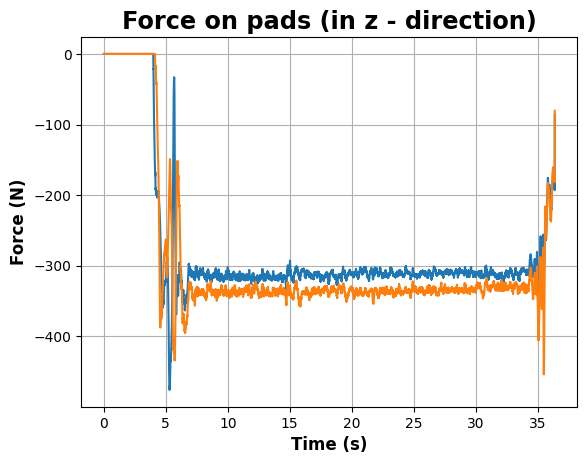

In [ ]:
force_plot(raw_data) # By plotting the force data Fz left and Fz right we can get an idea of when the hold was being held stable


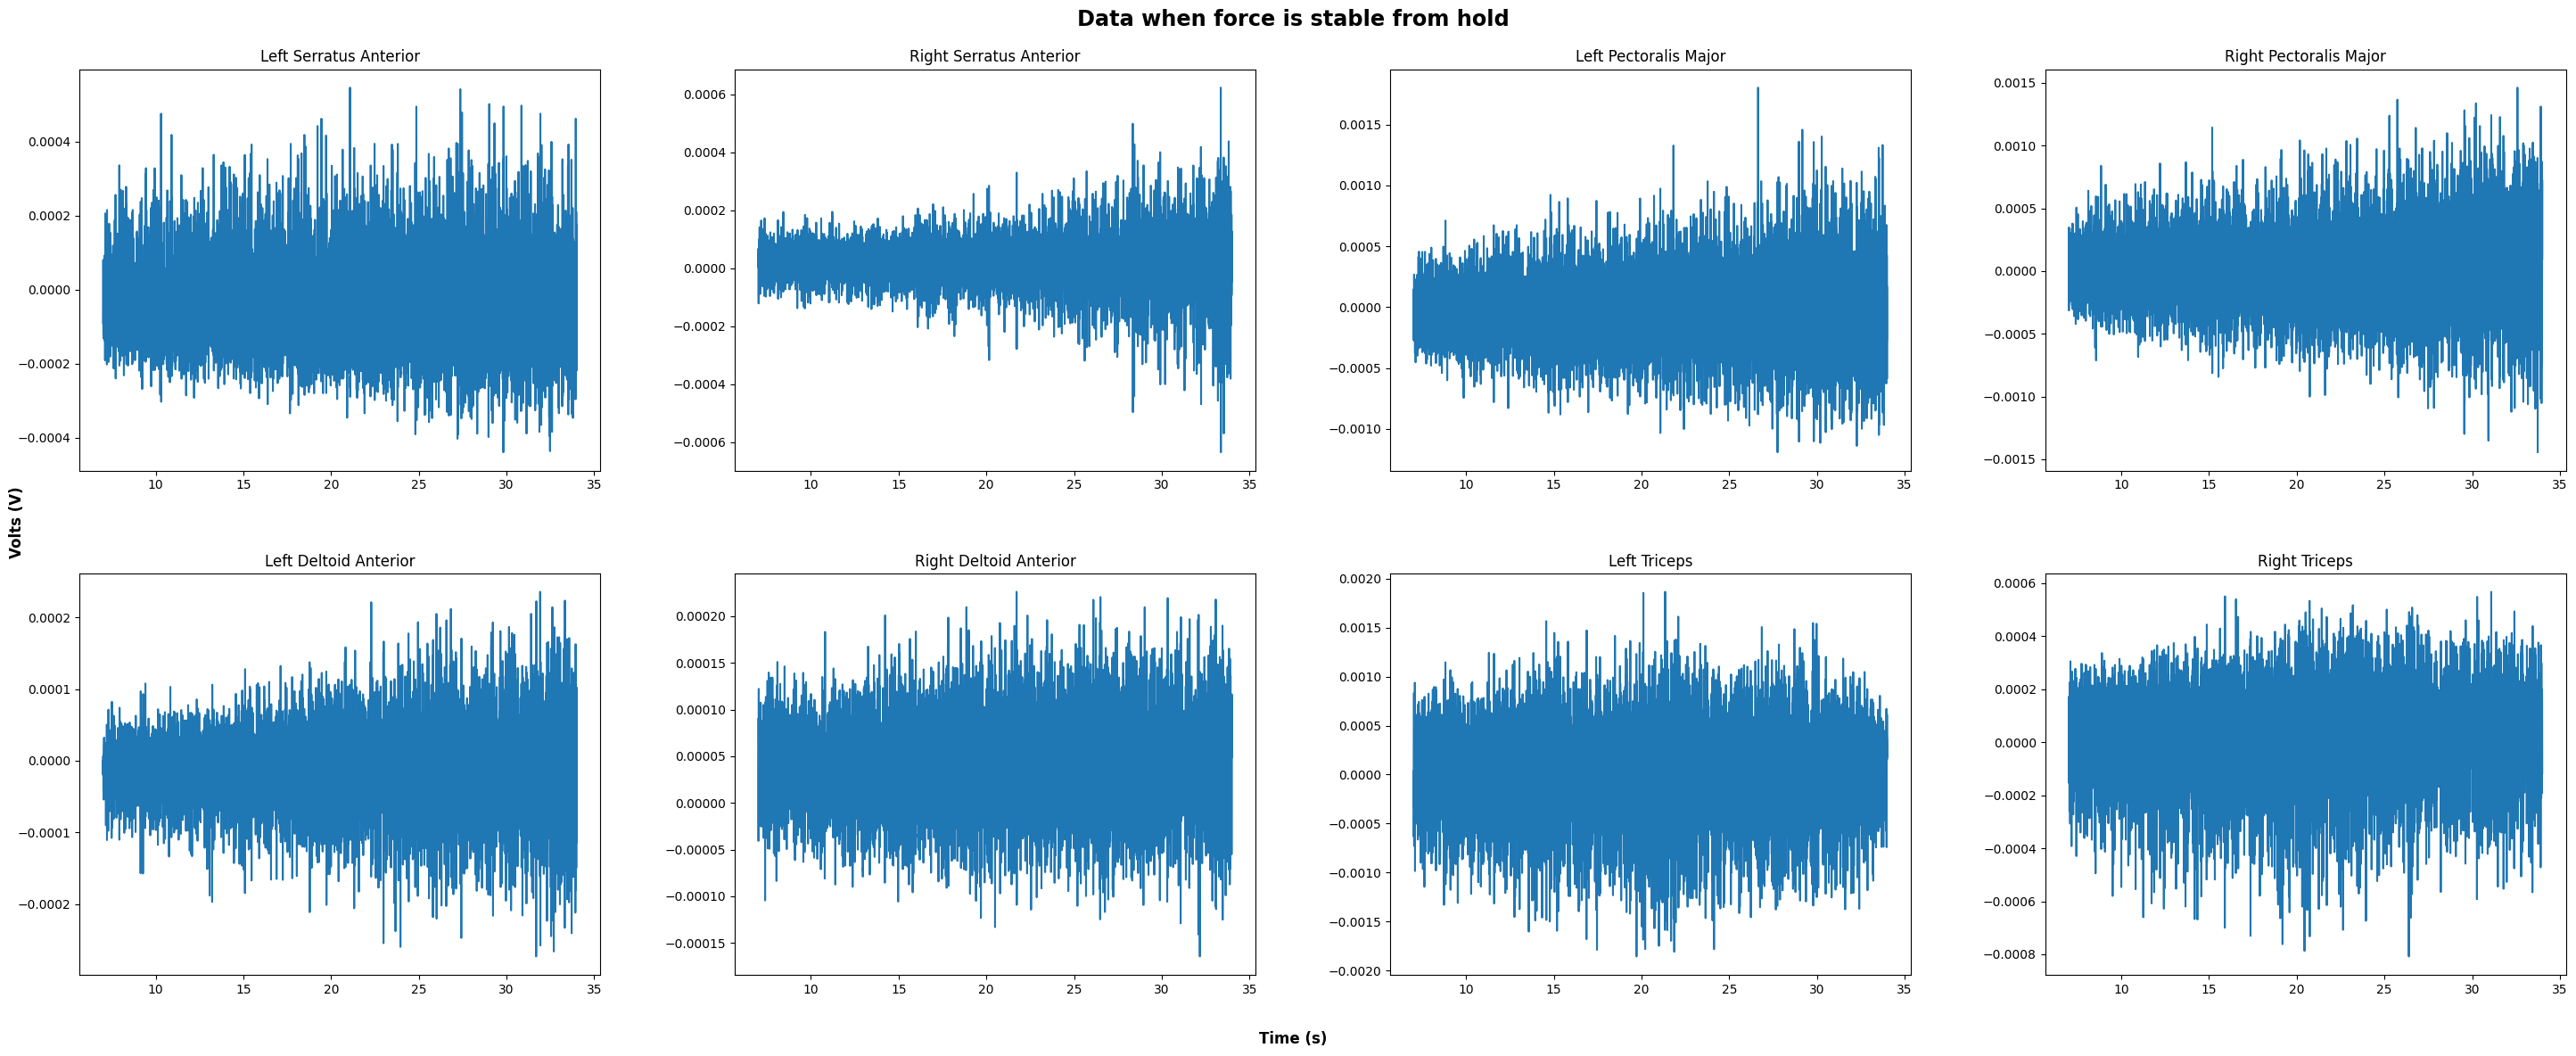

In [ ]:
# From the graph it is clear the data we want is when the force stays relatively constant between 7 and 34 seconds.
# These times also make sense when looking at the video of the person doing the hold.

low_cutoff_t = 7.
high_cutoff_t = 34.
hold_data = remove_unstable_Fz_data(raw_data, low_cutoff_t, high_cutoff_t) # This function removes times outside the cutoffs.
muscle_plots(hold_data, "Data when force is stable from hold") # Plotting to check how data has changed.

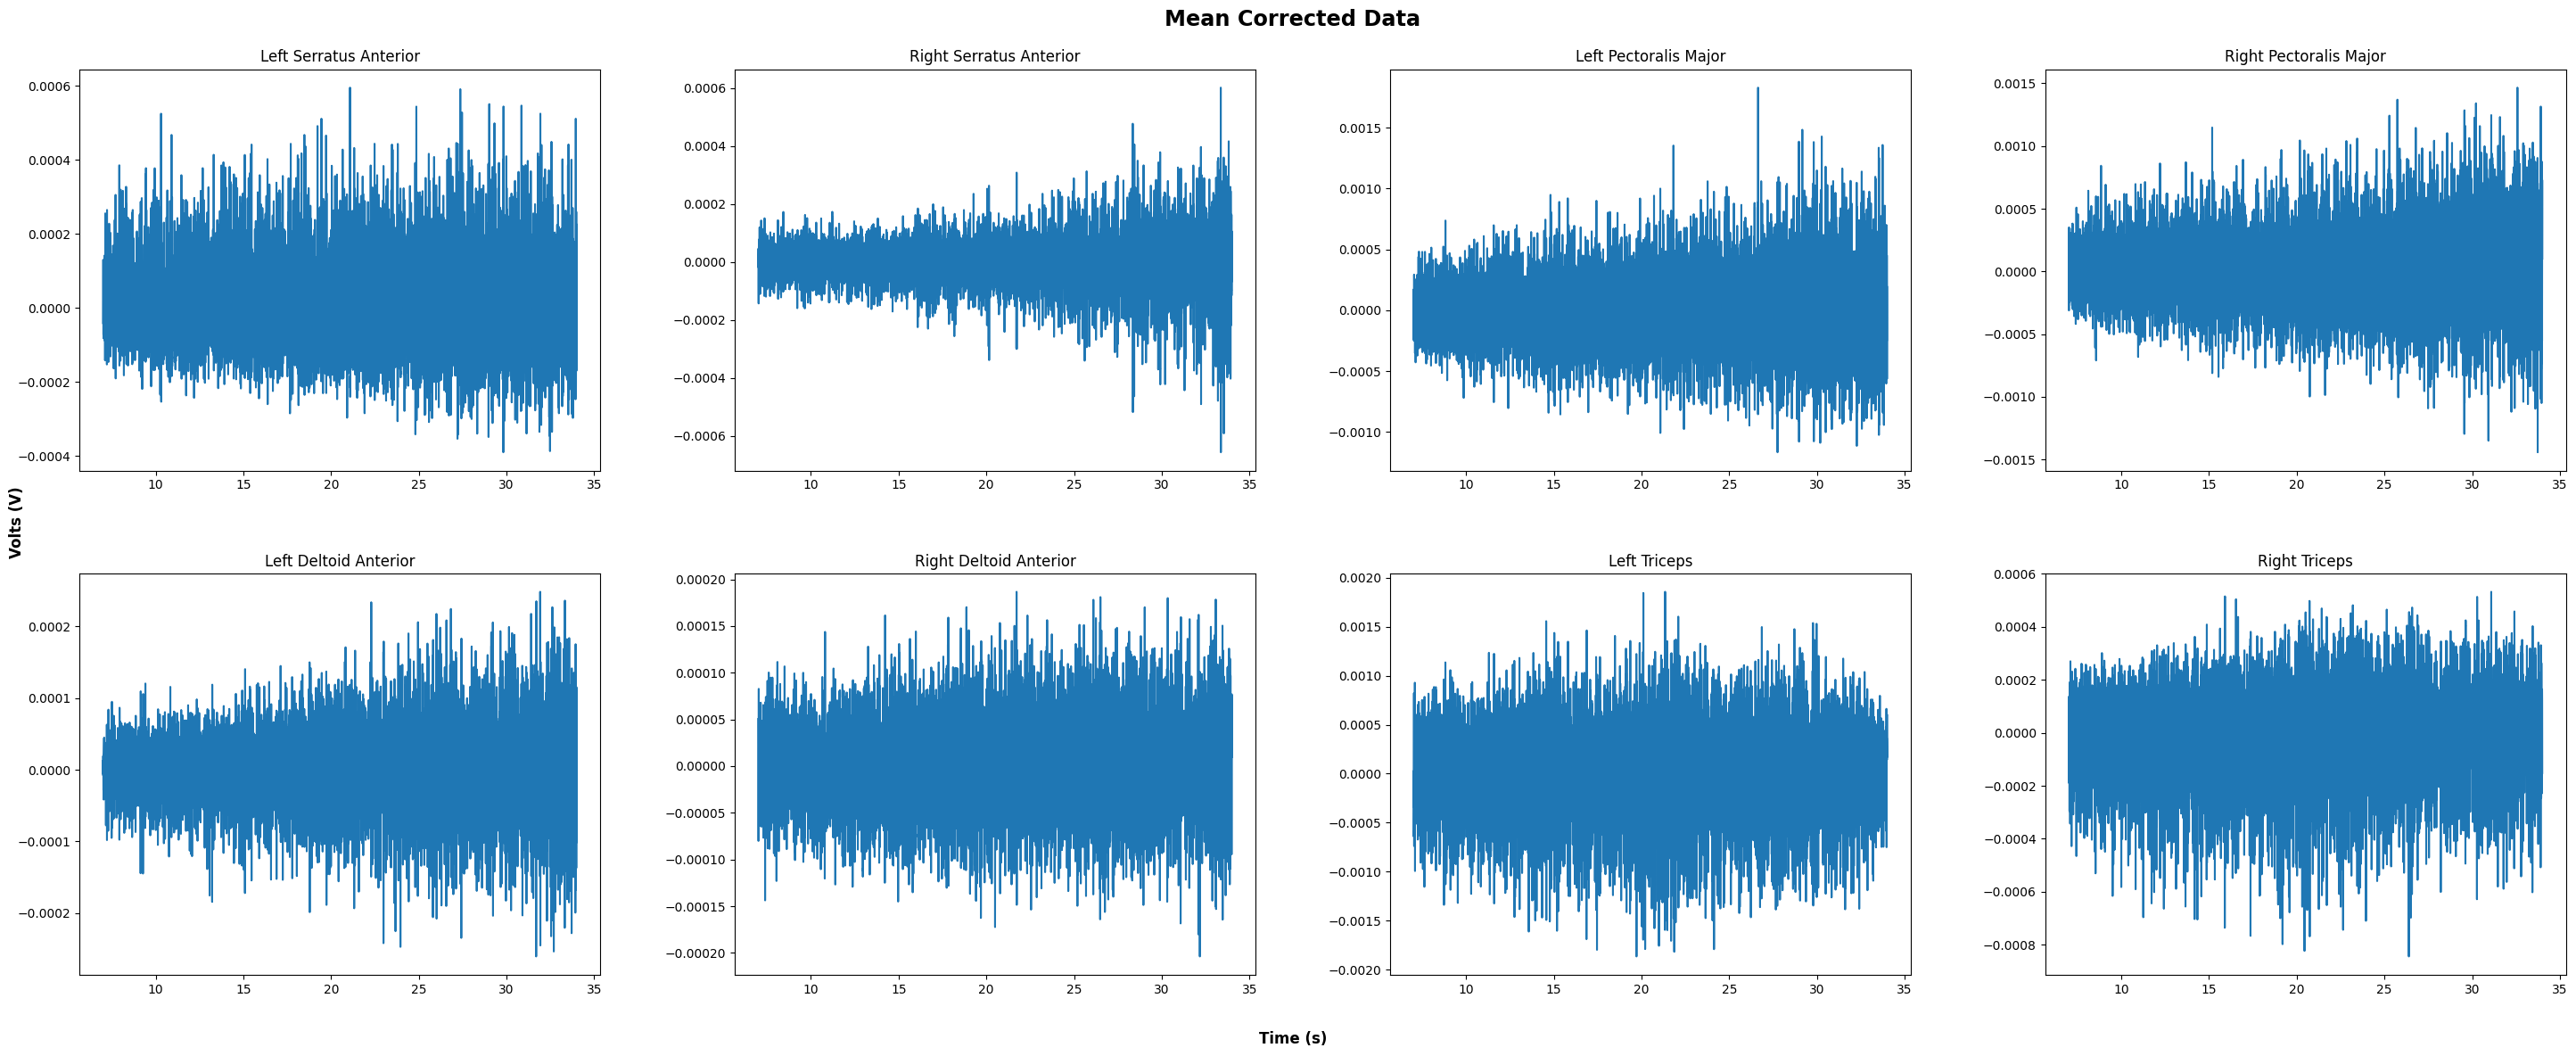

In [ ]:
offset_data = mean_offset(hold_data) # Running function to correct any offset using the mean and plotting it
muscle_plots(offset_data, "Mean Corrected Data") # Plotting to check how data has changed.

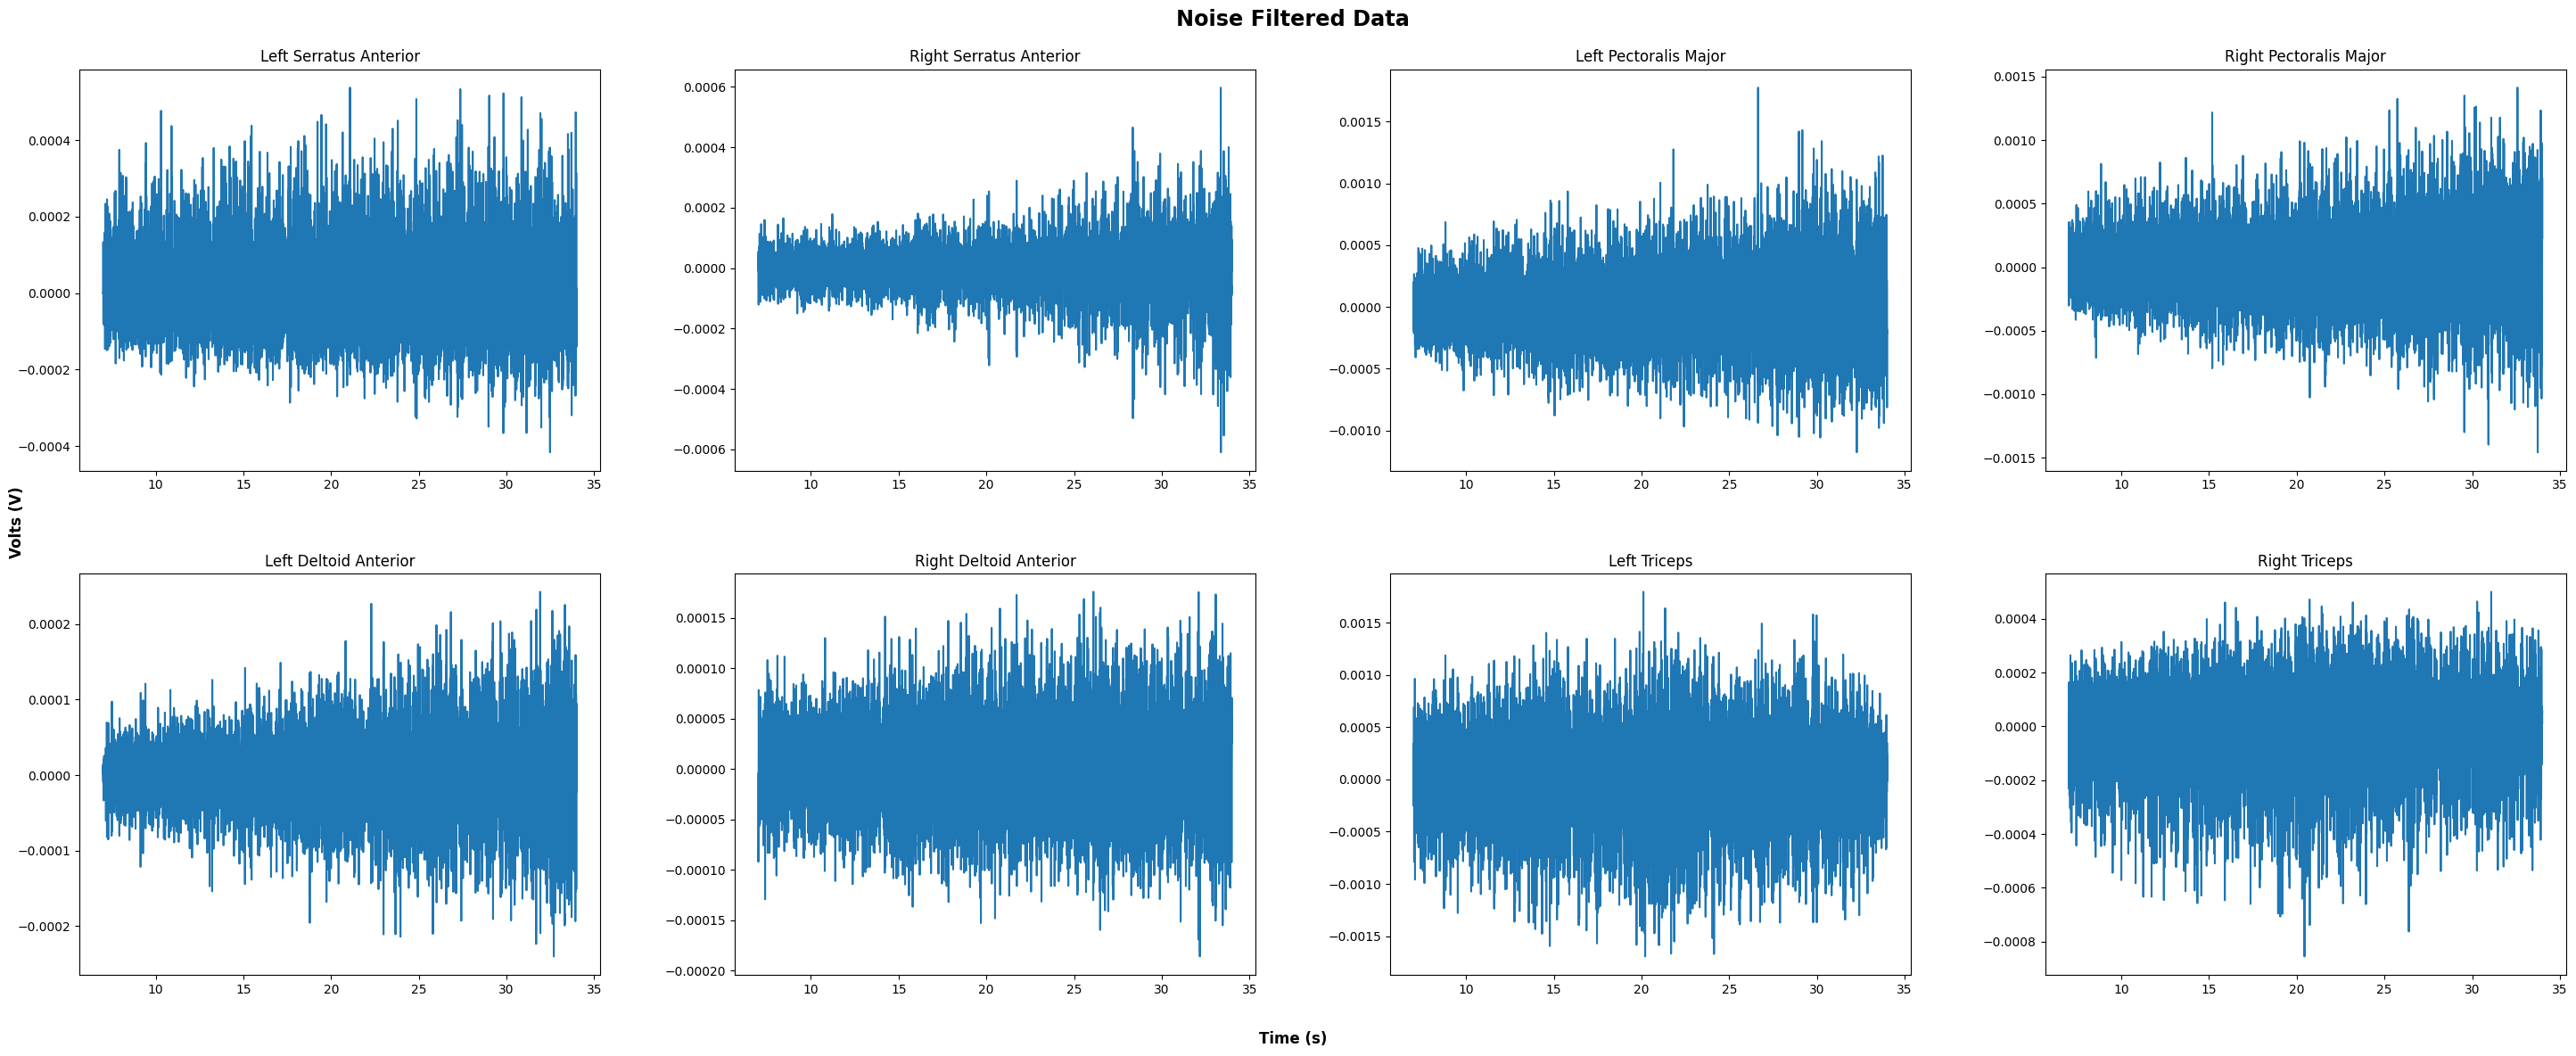

In [ ]:
# Doing Noise filtering

freqsample = 2160.  # Sample frequency given in the assignment
nyquistfreq = freqsample / 2. # Nyquist frequency is half the sampling frequency

# These variables define the range for our bandpass filtering and the notch filtering.
# The justification for filtering these frequencies as noise comes from [1]

lowcut_freq = 20.
highcut_freq = 450.
notchcut_freq = 50.

b, a = butter_bandpass(lowcut_freq, highcut_freq, nyquistfreq) # Butter function to filter using the two band pass filters
c, d = notch(notchcut_freq, freqsample) # Notch function to filter specific frequency

# Calling filtering function to filter the data using the outputs of the two filters.
bpfilt_data = noise_filter(b, a, offset_data)
noisefilt_data = noise_filter(c, d, bpfilt_data) # Finally have a usable data set after filtering.

muscle_plots(noisefilt_data, "Noise Filtered Data")  # Plotting to check how data has changed.

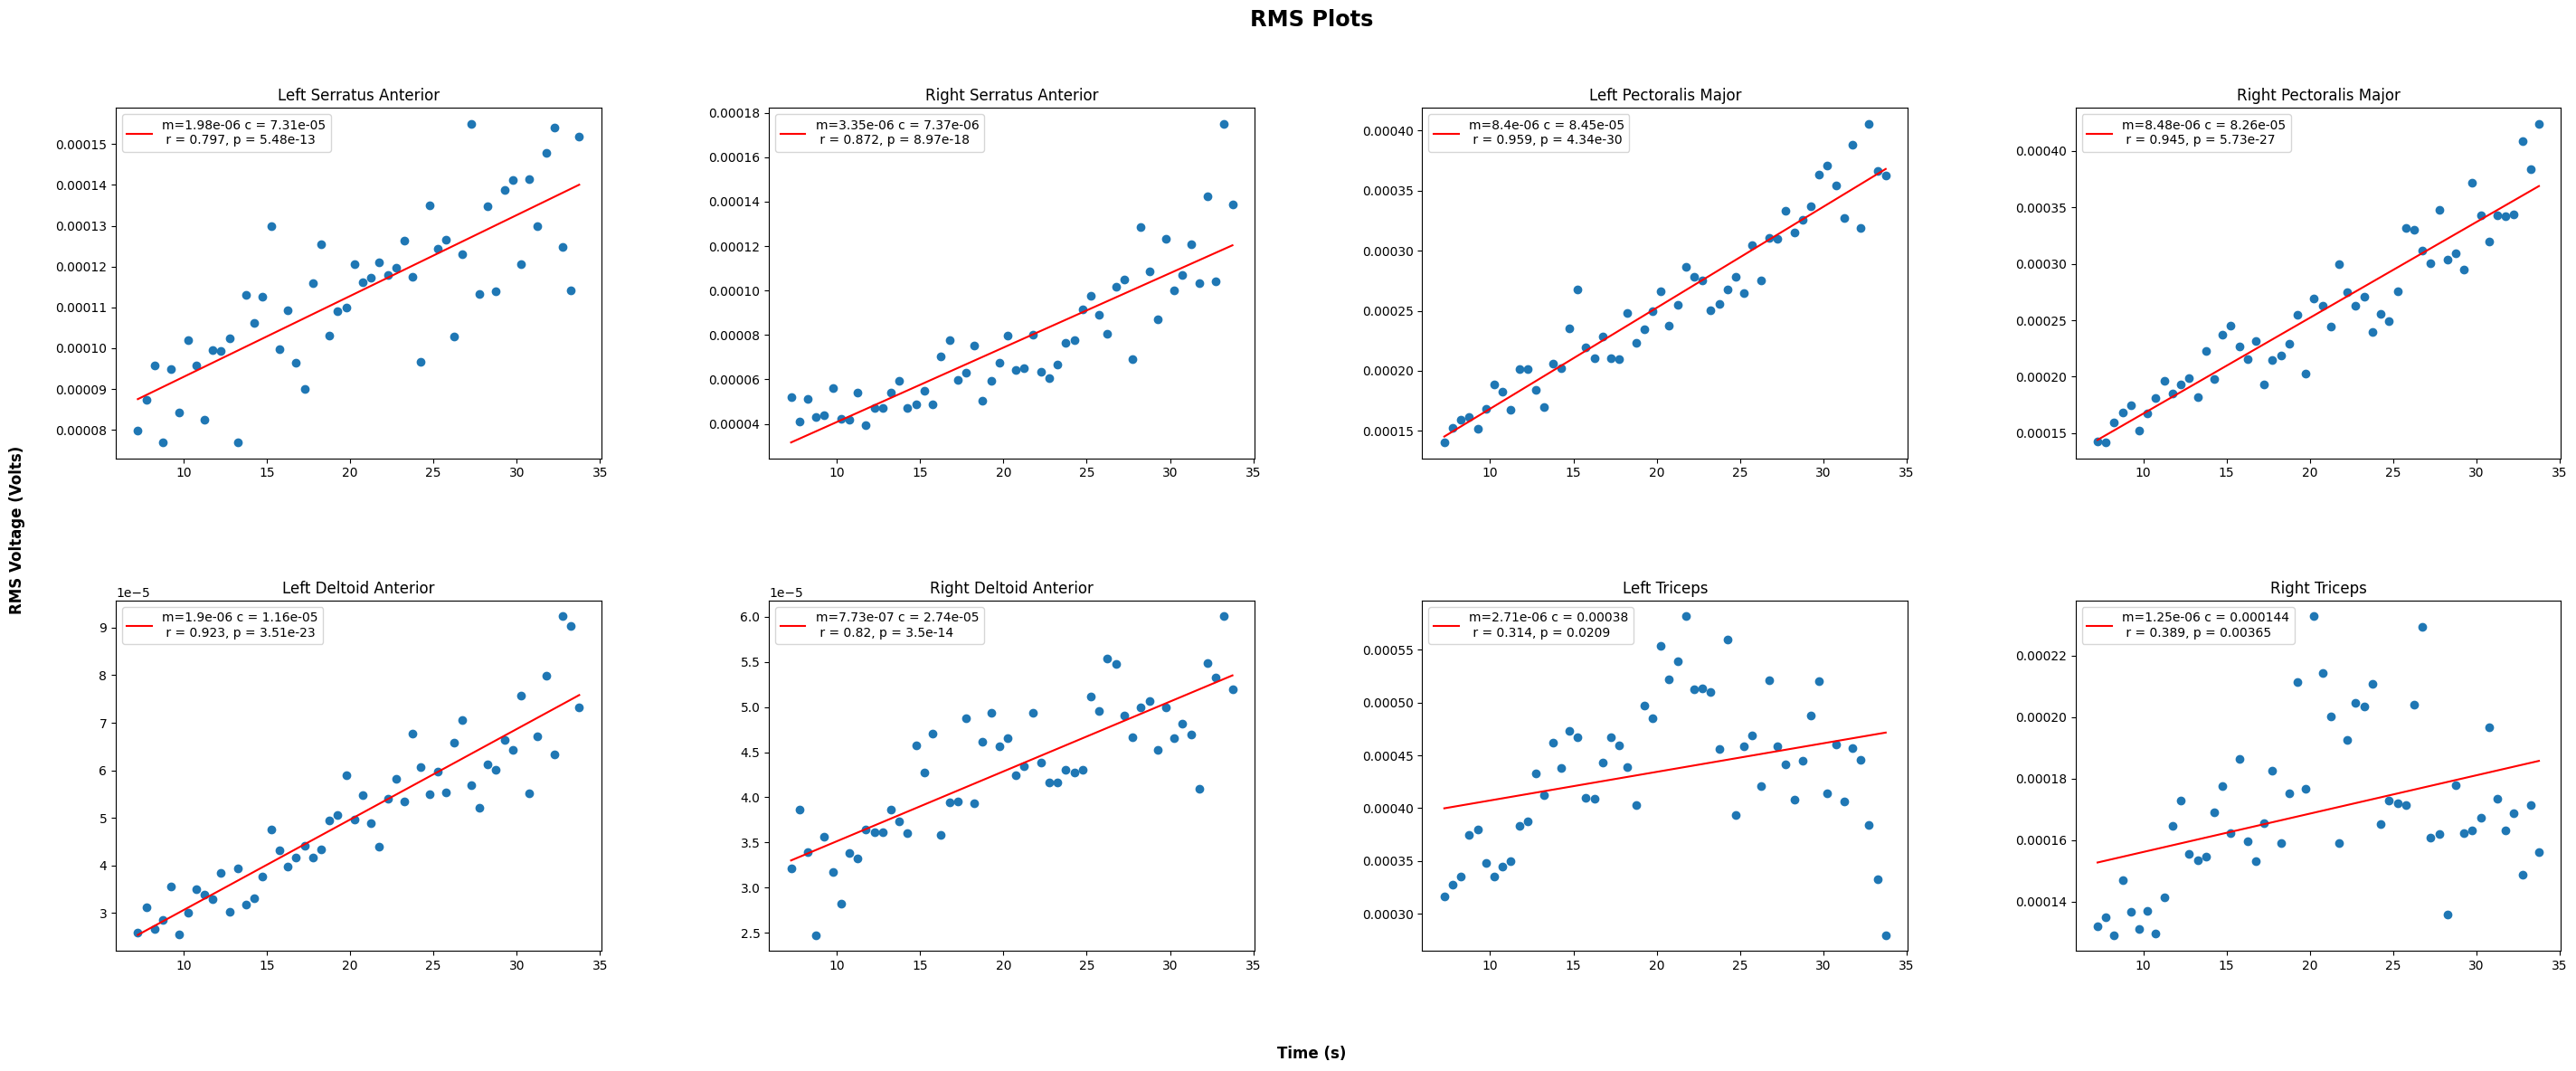

In [ ]:
rms = rms_calc(noisefilt_data) # Calculating the RMS for defined time windows.
scatter_plot(rms,'RMS Plots', 'RMS Voltage (Volts)') # Plotting the results of RMS vs time with linear fitting function
# Legend of fit contains gradient m, intercept c, Pearson correlation r, and p-value p

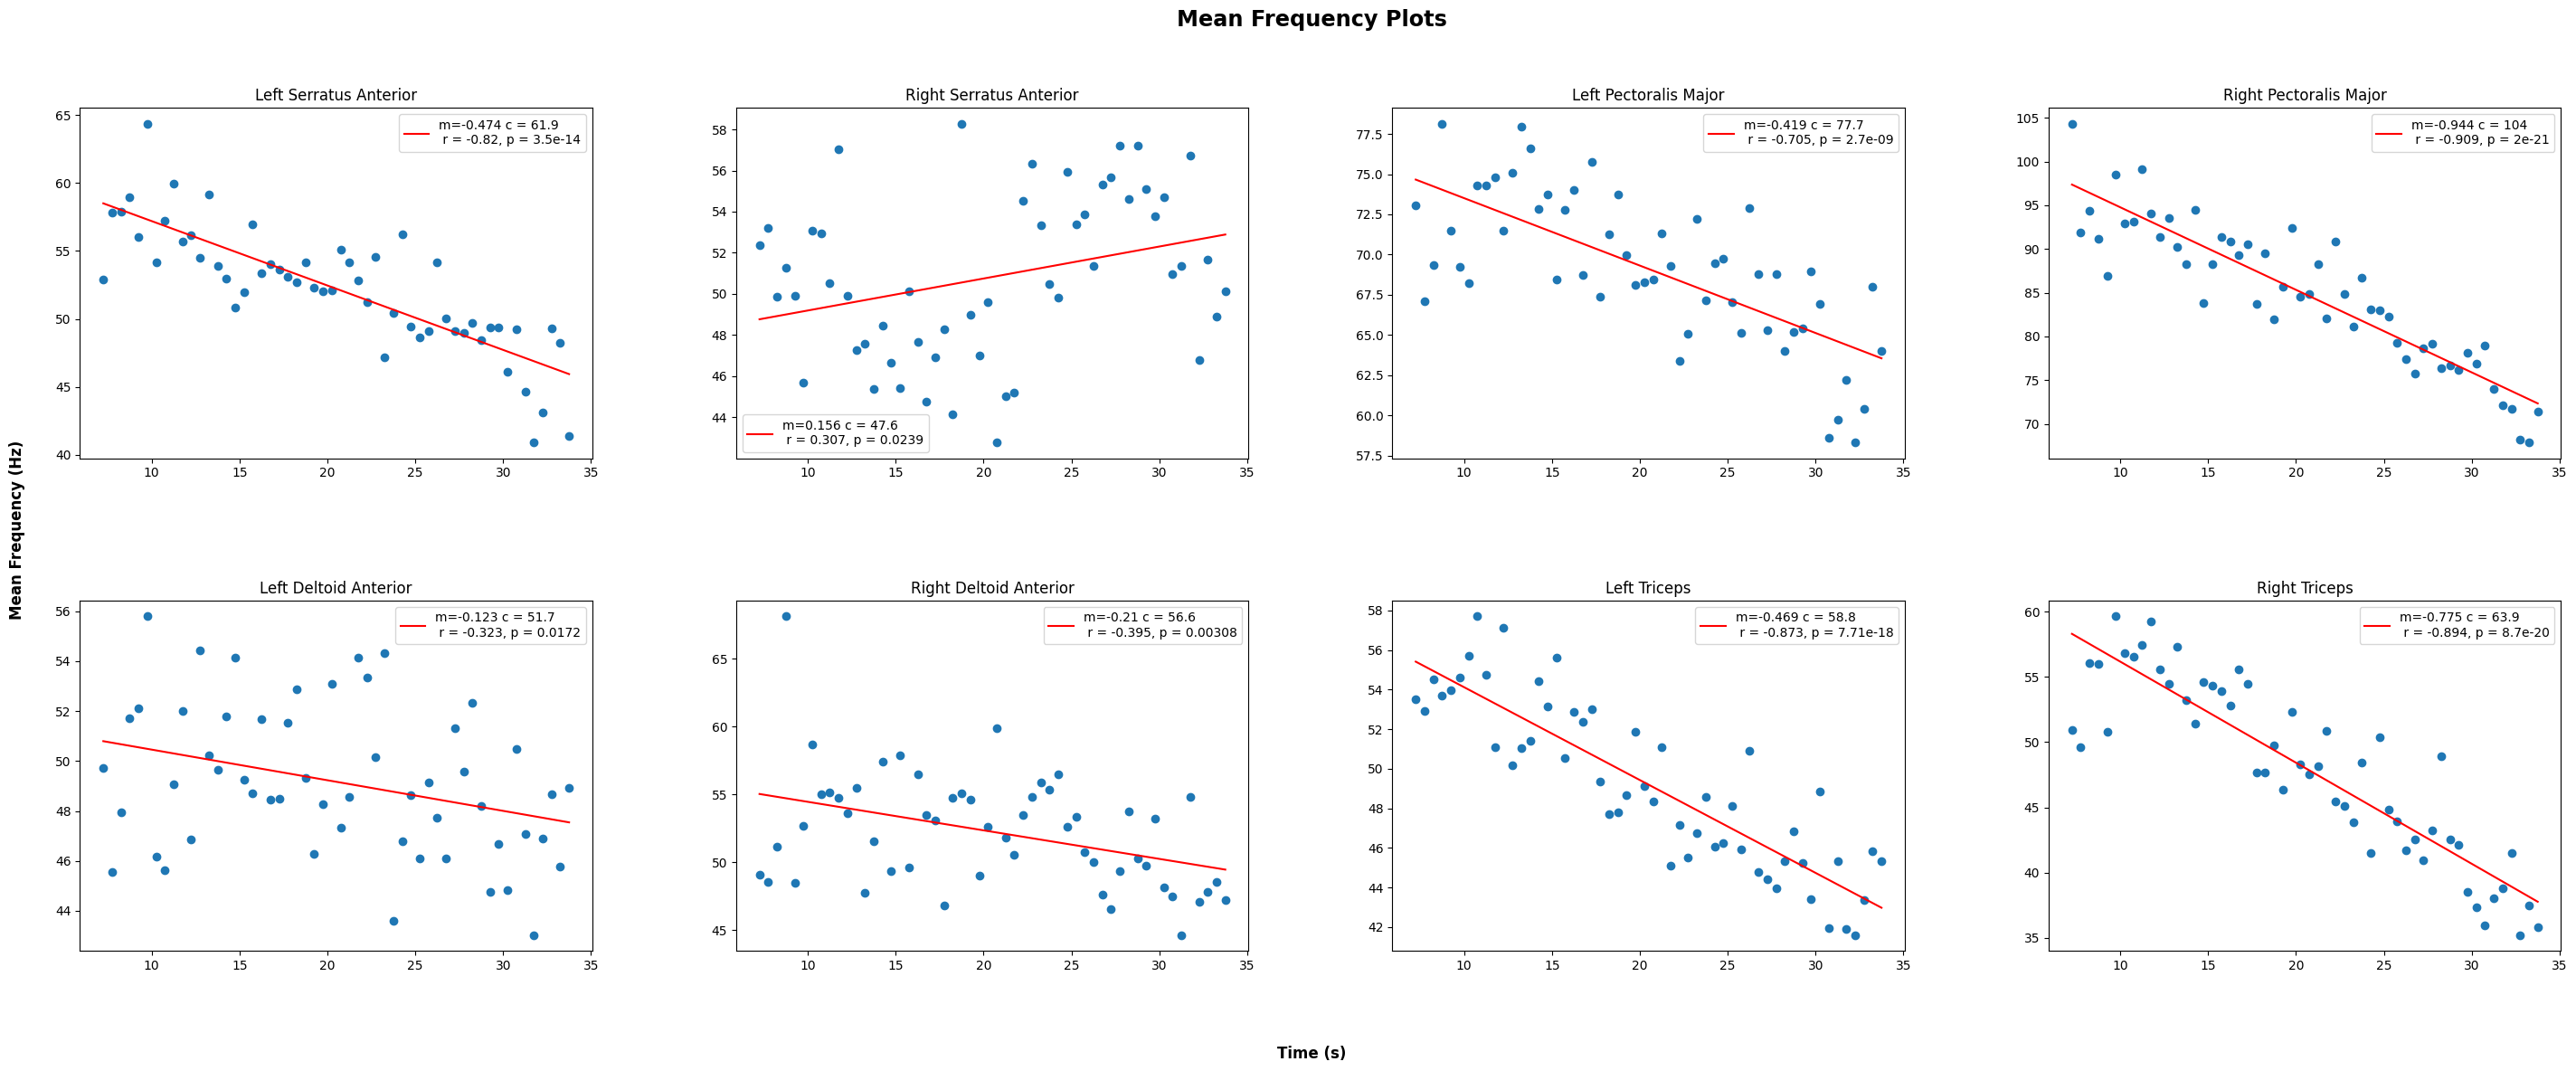

In [ ]:
mnf = mean_freq_calc(noisefilt_data) # Calculating the mean frequency for defined time windows.
scatter_plot(mnf, "Mean Frequency Plots", "Mean Frequency (Hz)") # Plotting the results of mean frequency vs time with linear fitting function
# Legend of fit contains gradient m, intercept c, Pearson correlation r, and p-value p

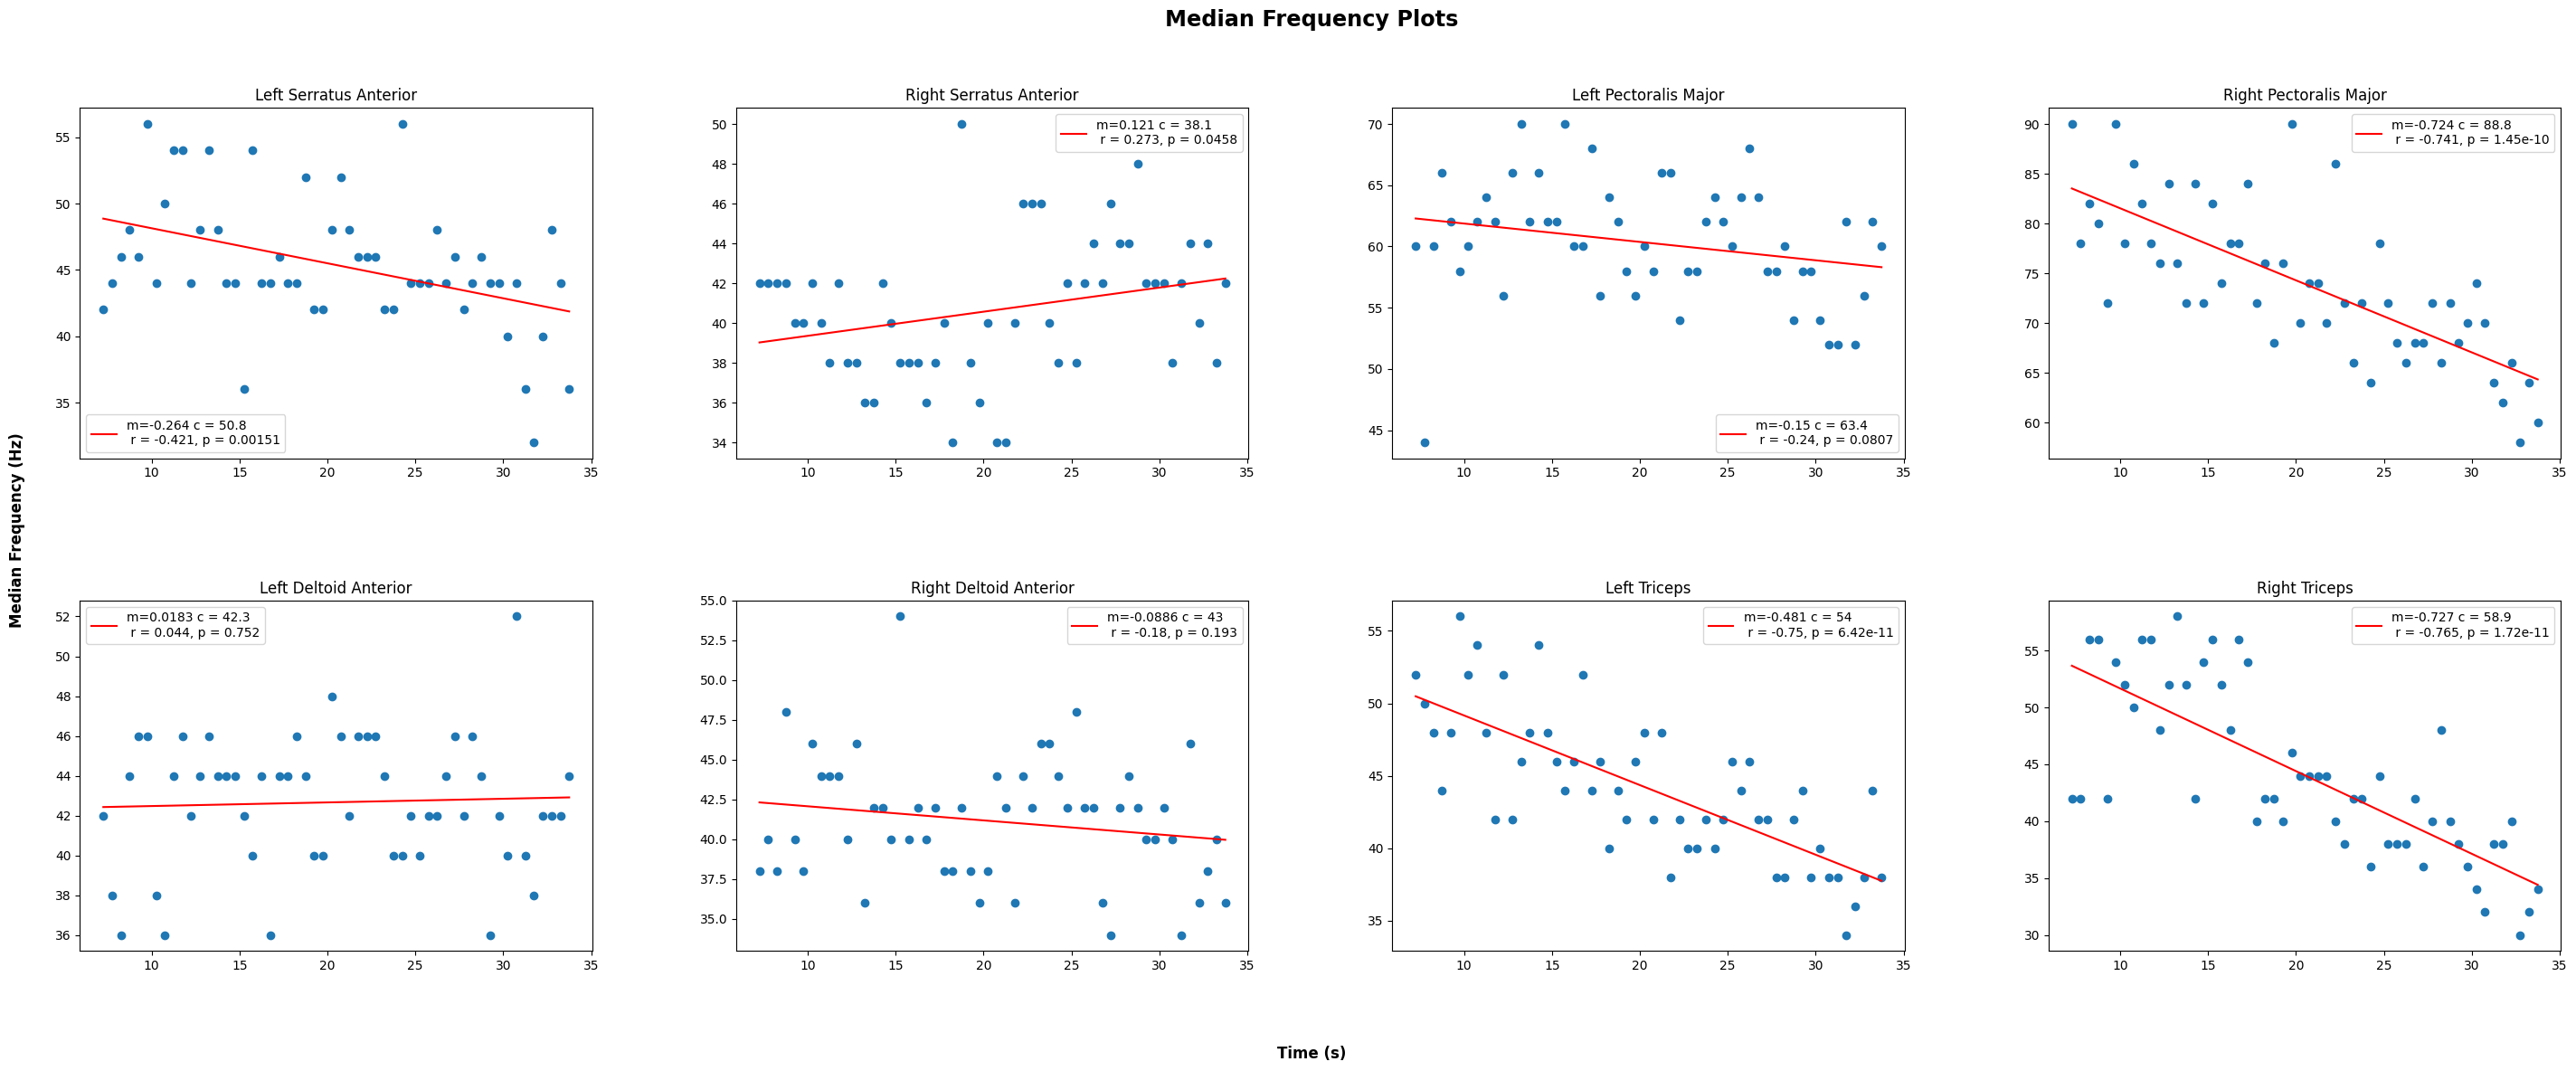

In [ ]:
mdf = median_freq_calc(noisefilt_data) # Calculating the median frequency for defined time windows.
scatter_plot(mdf, "Median Frequency Plots", "Median Frequency (Hz)") # Plotting the results of median frequency vs time with linear fitting function
# Legend of fit contains gradient m, intercept c, Pearson correlation r, and p-value p

From the plots produced we can see that using RMS we can see a linear increase in all the muscles except triceps indicating increasing fatigue as the hold keeps going. The triceps may have issues with amplitude of the voltage signal as when looking at the raw data there is a large difference in the amplitude of the voltages between the left and right triceps, although this could be due to an imbalance in the hold.

The mean frequency plots show a reasonably linear decrease in most muscles with exceptions for the deltoid muscles and the right serratus muscle (which actually shows an increase). It would be interesting to repeat this experiment to see if these results change or if it would be possible to look at isolated muscles working in simpler exercises that cause fatigue.

The median frequency only seems to show reasonable results for the triceps and the right pectoralis major. I am unsure of the reason behind this.
